Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

In [1]:
from math import sqrt
from itertools import permutations
from typing import Any
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class Tsp:
    def __init__(self, num_cities: int, seed: Any = None) -> None:
        if seed is None:
            seed = num_cities
        self._num_cities = num_cities
        self._graph = nx.DiGraph()
        np.random.seed(seed)
        for c in range(num_cities):
            self._graph.add_node(c, pos=(np.random.random(), np.random.random()))

    def distance(self, n1, n2) -> int:
        pos1 = self._graph.nodes[n1]["pos"]
        pos2 = self._graph.nodes[n2]["pos"]
        return round(
            1_000_000
            / self._num_cities
            * sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)
        )

    def evaluate_solution(self, solution: np.array) -> float:
        total_cost = 0
        tmp = solution.tolist() + [solution[0]]
        for n1, n2 in (tmp[i : i + 2] for i in range(len(tmp) - 1)):
            total_cost += self.distance(n1, n2)
        return total_cost

    def plot(self, path: np.array = None) -> None:
        if path is not None:
            self._graph.remove_edges_from(list(self._graph.edges))
            tmp = path.tolist() + [path[0]]
            for n1, n2 in (tmp[i : i + 2] for i in range(len(tmp) - 1)):
                self._graph.add_edge(n1, n2)
        plt.figure(figsize=(12, 5))
        nx.draw(
            self._graph,
            pos=nx.get_node_attributes(self._graph, "pos"),
            with_labels=True,
            node_color="pink",
        )
        if path is not None:
            plt.title(f"Current path: {self.evaluate_solution(path):,}")
        plt.show()

    @property
    def graph(self) -> nx.digraph:
        return self._graph

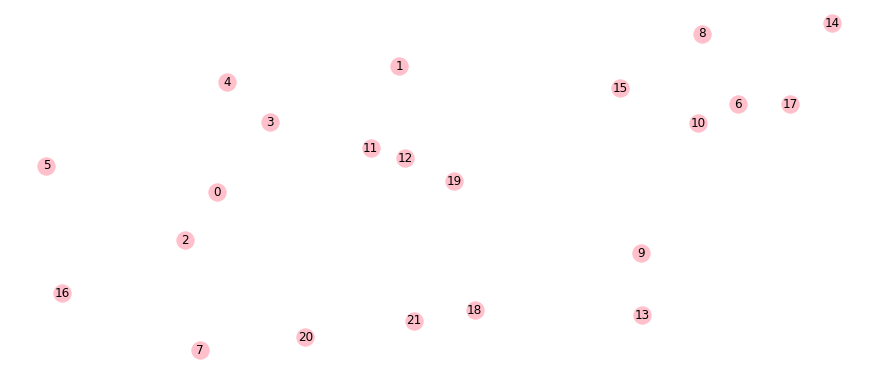

In [3]:
NUM_CITIES = 22

problem = Tsp(NUM_CITIES)
problem.plot()

## Simple Heuristic

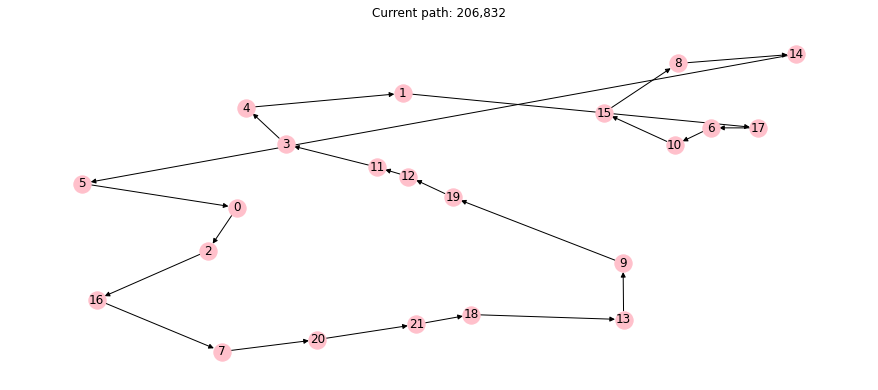

In [4]:
G = nx.Graph()
G.add_nodes_from(problem.graph.nodes())
for n1, n2, _ in sorted(
    [
        (n1, n2, problem.distance(n1, n2))
        for n1, n2 in permutations(problem.graph.nodes(), 2)
    ],
    key=lambda t: t[2],
):
    if len(G.edges(n1)) < 2 and len(G.edges(n2)) < 2:
        G.add_edge(n1, n2)
        try:
            nx.find_cycle(G)
            G.remove_edge(n1, n2)
        except:
            pass

G.add_edge(*[n for n in G if len(G.edges(n)) < 2])
solution = np.array([0] + [n[0] for n in nx.dfs_successors(G, 0).values()])
problem.plot(solution)

## Random-Mutation Hill Climber

In [5]:
def tweak(solution: np.array, *, pm: float = 1 / NUM_CITIES) -> np.array:
    new_solution = solution.copy()
    p = None
    while p is None or p < pm:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        temp = new_solution[i1]
        new_solution[i1] = new_solution[i2]
        new_solution[i2] = temp
        p = np.random.random()
    return new_solution

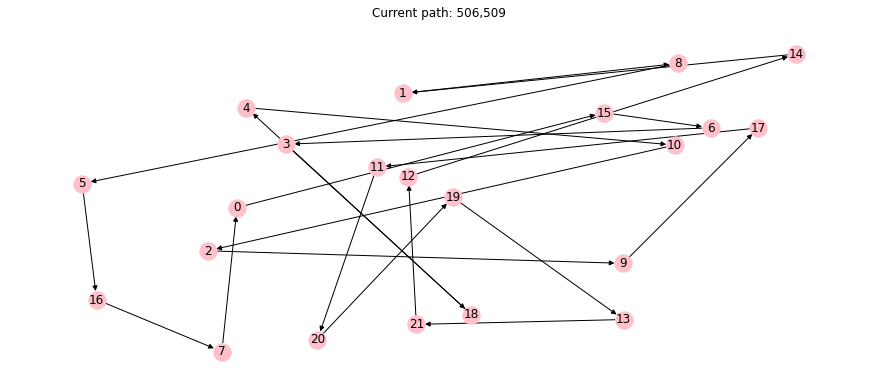

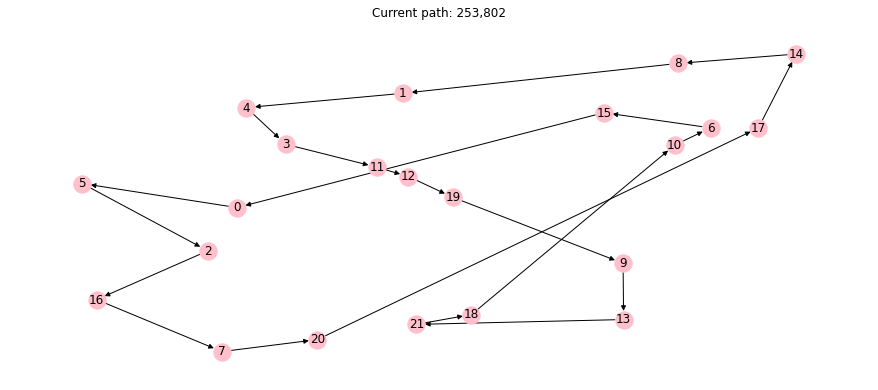

In [6]:
STEADY_STATE = 1000

solution = np.array(range(NUM_CITIES))
np.random.shuffle(solution)
solution_cost = problem.evaluate_solution(solution)
problem.plot(solution)

history = [(0, solution_cost)]
steady_state = 0
step = 0
while steady_state < STEADY_STATE:
    step += 1
    steady_state += 1
    new_solution = tweak(solution, pm=0.5)
    new_solution_cost = problem.evaluate_solution(new_solution)
    if new_solution_cost < solution_cost:
        solution = new_solution
        solution_cost = new_solution_cost
        history.append((step, solution_cost))
        steady_state = 0
problem.plot(solution)